# PRESELECCIÓN DE VARIABLES

#### nota teorica

Interesa hacer una modelización masiva

¿por que?

Para cada uno de esos productos se va a hacer esa modelizacion, porque para un almacen un producto puede ser predictivo y para otro no

Se va a recorrer packs de almacen-producto para ver que es lo que funciona y que es lo que no.

No es un modelo individual que encaja en todo el flujo, ahora voy a hacer unos modelos a aparte adhoc

Ahora de momento voy a construir el proceso.

## IMPORTAR PAQUETES

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance


#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

Sustituir la ruta del proyecto.

In [11]:
ruta_proyecto = '../../'

Nombres de los ficheros de datos.

In [12]:
nombre_df = 'df_tablon.pickle'

Cargar los datos.

In [13]:
df = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_df)

In [14]:
df = df.set_index('date')

## MÉTODOS SUPERVISADOS

### Preparar x e y

In [15]:
target = 'ventas'
x = df.drop(columns = ['warehouse_id','item_id','ventas']).copy()
y =  df[target].copy()

### Mutual Information

In [16]:
y

date
2013-01-16    191
2013-01-17    170
2013-01-18    224
2013-01-19    362
2013-01-20    255
             ... 
2015-11-26     22
2015-11-27     10
2015-11-28     17
2015-11-29      7
2015-11-30      9
Name: ventas, Length: 20925, dtype: int64

In [17]:
x

,year_2013,year_2014,year_2015,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,ventas_maxm_6,ventas_maxm_7,ventas_maxm_8,ventas_maxm_9,ventas_maxm_10,ventas_maxm_11,ventas_maxm_12,ventas_maxm_13,ventas_maxm_14,ventas_maxm_15
date,,,,,,,,,,,,,,,,,,,,,
2013-01-16,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-17,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-18,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-19,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-20,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-26,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,15.0,15.0,15.0,15.0,17.0,17.0,17.0,17.0,17.0
2015-11-27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
2015-11-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0


#### Crear una función para mostrar el resultado

In [18]:
def ranking_mi(mutual_selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return(ranking_mi)
    else:
        g = ranking_mi.importancia_mi.sort_values().plot.barh(figsize = (12,20))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importancia_mi').variable)
        return(g)

#### Calcular y revisar

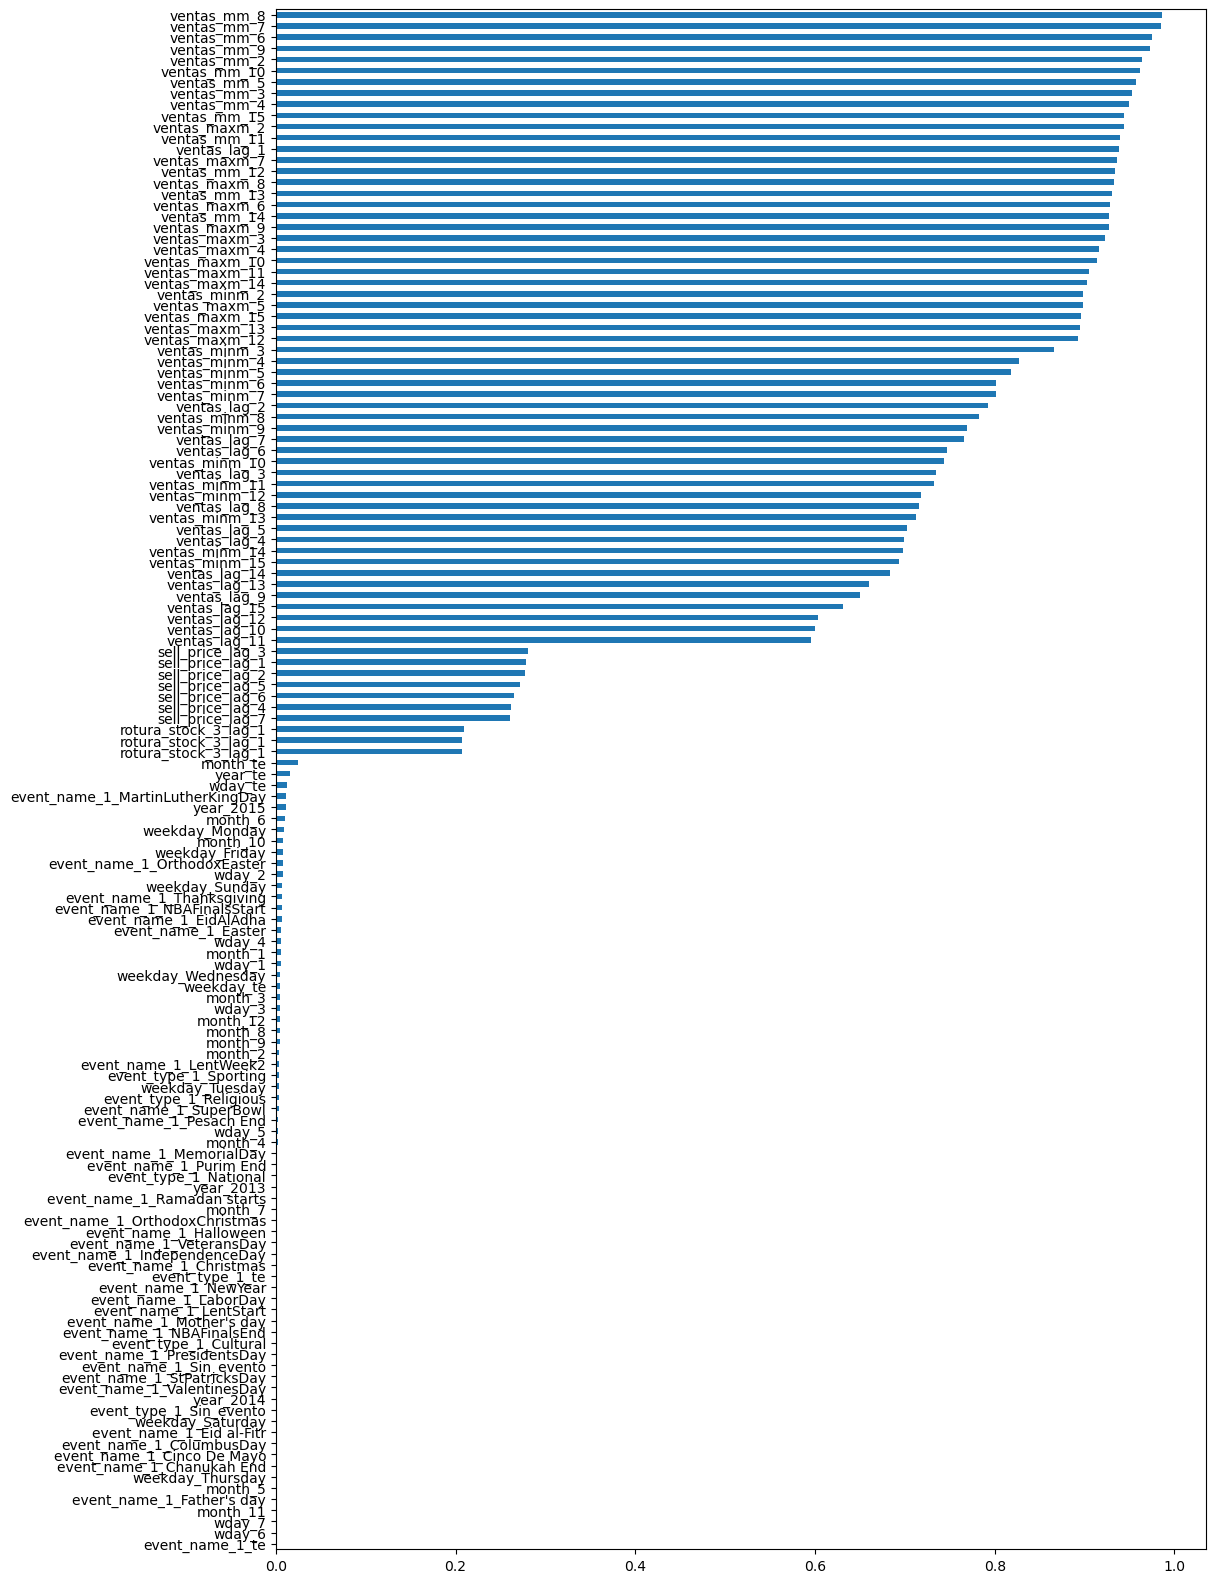

In [19]:
mutual_selector = mutual_info_regression(x,y)

rank_mi = ranking_mi(mutual_selector, modo = 'grafico')

Tiene un degradado bastante progresivo a nivel de la importancia de las variables. La mitad ultima no interesa que las pase.

Le voy a pasar un pull mas reducido, para que sea mas rapido, y luego si puedo recorto incluso mas.

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

Miro la posición del year2014.

In [20]:
ranking_mi(mutual_selector).reset_index().iloc[60:100]

,index,variable,importancia_mi,ranking_mi
60,75,sell_price_lag_5,0.271856,60
61,76,sell_price_lag_6,0.265070,61
62,74,sell_price_lag_4,0.261073,62
63,77,sell_price_lag_7,0.260285,63
64,79,rotura_stock_3_lag_1,0.209685,64
65,78,rotura_stock_3_lag_1,0.207024,65
66,80,rotura_stock_3_lag_1,0.206774,66
67,66,month_te,0.023986,67
68,65,year_te,0.015207,68
69,67,wday_te,0.011872,69


In [21]:
posicion_variable_limite = 72

##### Extraer los nombres de las que entran

In [22]:
entran_mi = ranking_mi(mutual_selector).iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [23]:
x_mi = x[entran_mi].copy()

### Recursive Feature Elimination

#### Instanciar

In [24]:
rfe = RFE(estimator = XGBRegressor(use_label_encoder=False, n_jobs = -1, eval_metric='mae'))

#### Entrenar

In [25]:
rfe.fit(x,y)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, early_stopping_rounds=None,
                           enable_categorical=False, eval_metric='mae',
                           feature_types=None, gamma=None, gpu_id=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=-1, num_parallel_tree=None, predictor=None,
                           random_state=None, ...))

##### Extraer los nombres de las que entran

In [26]:
entran_rfe = x.columns[rfe.support_]

#### Crear el dataframe con la selección

In [27]:
x_rfe = x[entran_rfe].copy()

In [28]:
x_rfe

,year_2013,month_3,month_8,month_11,month_12,wday_1,wday_2,wday_4,event_name_1_Christmas,event_name_1_VeteransDay,...,ventas_maxm_5,ventas_maxm_6,ventas_maxm_8,ventas_maxm_9,ventas_maxm_10,ventas_maxm_11,ventas_maxm_12,ventas_maxm_13,ventas_maxm_14,ventas_maxm_15
date,,,,,,,,,,,,,,,,,,,,,
2013-01-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-19,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,224.0,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2013-01-20,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-26,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,15.0,15.0,15.0,15.0,17.0,17.0,17.0,17.0,17.0
2015-11-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
2015-11-28,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0


### Permutation Importance

#### Crear una función para mostrar el resultado

In [29]:
def ranking_per(predictoras,permutacion):
    ranking_per = pd.DataFrame({'variable': predictoras.columns, 'importancia_per': permutacion.importances_mean}).sort_values(by = 'importancia_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instanciar y entrenar

In [30]:
x.columns[x.columns.duplicated()]

Index(['rotura_stock_3_lag_1', 'rotura_stock_3_lag_1'], dtype='object')

Tengo duplicadas, asi que selecciono las no duplicadas

In [31]:
# Identificar y eliminar columnas duplicadas
x = x.loc[:,~x.columns.duplicated()]

print(x)


            year_2013  year_2014  year_2015  month_1  month_2  month_3  \
date                                                                     
2013-01-16        1.0        0.0        0.0      1.0      0.0      0.0   
2013-01-17        1.0        0.0        0.0      1.0      0.0      0.0   
2013-01-18        1.0        0.0        0.0      1.0      0.0      0.0   
2013-01-19        1.0        0.0        0.0      1.0      0.0      0.0   
2013-01-20        1.0        0.0        0.0      1.0      0.0      0.0   
...               ...        ...        ...      ...      ...      ...   
2015-11-26        0.0        0.0        1.0      0.0      0.0      0.0   
2015-11-27        0.0        0.0        1.0      0.0      0.0      0.0   
2015-11-28        0.0        0.0        1.0      0.0      0.0      0.0   
2015-11-29        0.0        0.0        1.0      0.0      0.0      0.0   
2015-11-30        0.0        0.0        1.0      0.0      0.0      0.0   

            month_4  month_5  month_6

In [32]:
x.columns

Index(['year_2013', 'year_2014', 'year_2015', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7',
       ...
       'ventas_maxm_6', 'ventas_maxm_7', 'ventas_maxm_8', 'ventas_maxm_9',
       'ventas_maxm_10', 'ventas_maxm_11', 'ventas_maxm_12', 'ventas_maxm_13',
       'ventas_maxm_14', 'ventas_maxm_15'],
      dtype='object', length=136)

In [33]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBRegressor(use_label_encoder=False, n_jobs = -1, eval_metric='mae')

xgb.fit(x,y)

permutacion = permutation_importance(xgb, 
                                     x, y, 
                                     scoring = 'neg_mean_absolute_percentage_error',
                                     n_repeats=3, n_jobs = -1)

#### Revisar la salida

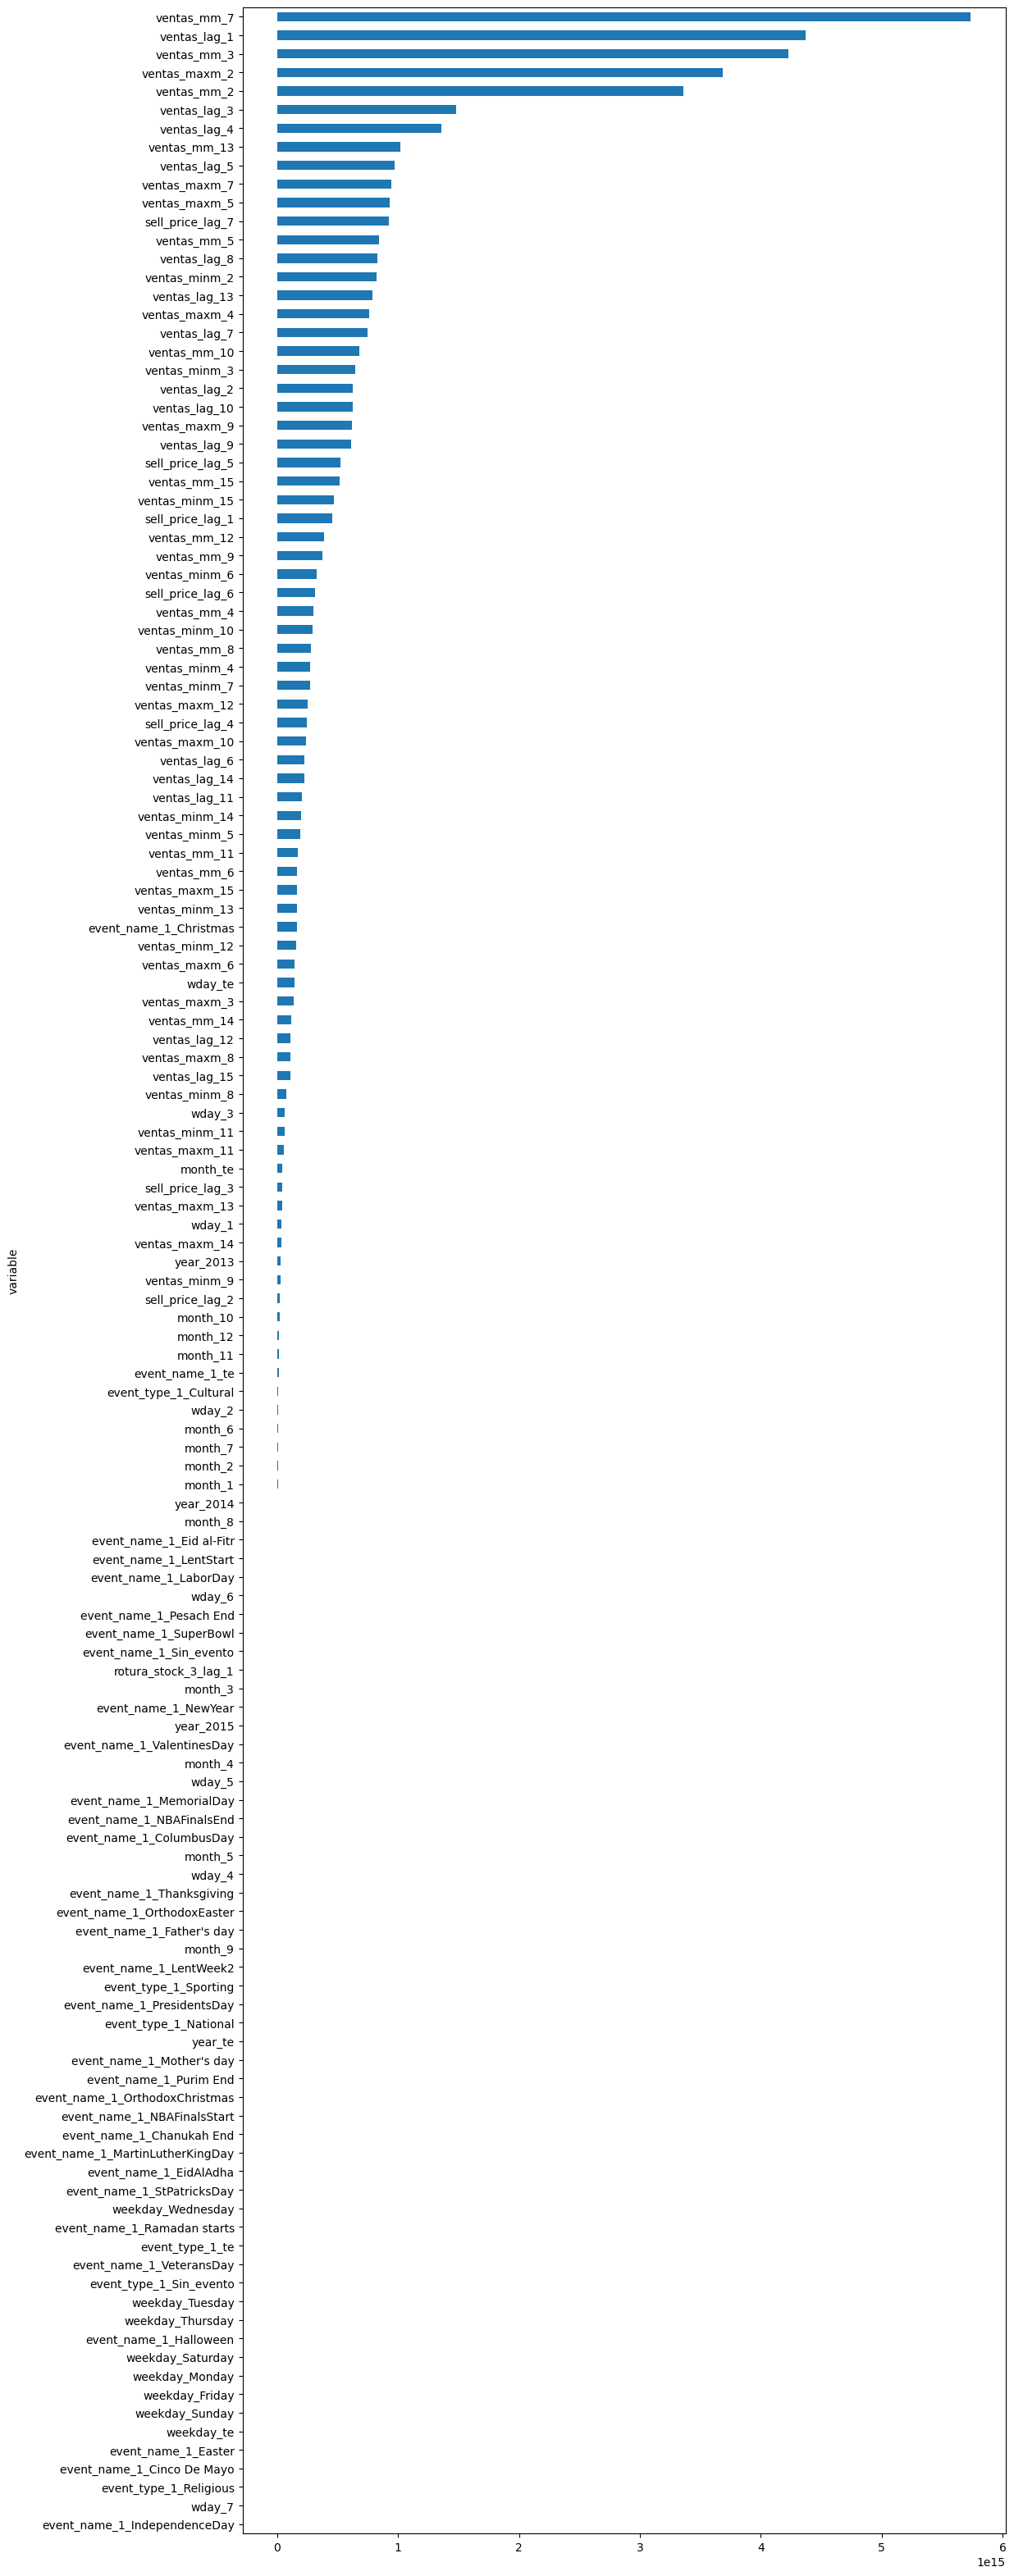

In [34]:
rank_per = ranking_per(x,permutacion)

rank_per.set_index('variable').importancia_per.sort_values().plot.barh(figsize = (12,40));

Esta salida me gusta menos porque selecciona muy pocas varaibles, no es que sea incorrecto, mi objetivo es coger un pull de variables para que el propio LightGBM ya seleccione las mejores

Si fuera un modelo de regresion lineal quizas si me interesase más porque en ese caso le paso las variables al modelo, por lo que me interesaria mas concentrar mas capacidad predictiva alli.

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

Revisar la posición de wday3.

In [35]:
rank_per.reset_index().iloc[50:100]

,index,variable,importancia_per,ranking_per
50,104,ventas_minm_12,1.576049e+14,50
51,126,ventas_maxm_6,1.440907e+14,51
52,67,wday_te,1.418886e+14,52
53,123,ventas_maxm_3,1.341098e+14,53
54,120,ventas_mm_14,1.146328e+14,54
55,90,ventas_lag_12,1.116769e+14,55
56,128,ventas_maxm_8,1.093275e+14,56
57,93,ventas_lag_15,1.073585e+14,57
58,100,ventas_minm_8,7.231171e+13,58
59,17,wday_3,6.226299e+13,59


In [36]:
posicion_variable_limite = 69

##### Extraer los nombres de las que entran

In [37]:
entran_per = rank_per.iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [38]:
x_per = x[entran_per].copy()

## SELECCIONAR EL MÉTODO FINAL

In [39]:
x_preseleccionado = x_mi 
#x_preseleccionado = x_rfe
#x_preseleccionado = x_per

In [40]:
df = df.reset_index()

In [41]:
df.head()

,date,warehouse_id,item_id,year_2013,year_2014,year_2015,month_1,month_2,month_3,month_4,...,ventas_maxm_6,ventas_maxm_7,ventas_maxm_8,ventas_maxm_9,ventas_maxm_10,ventas_maxm_11,ventas_maxm_12,ventas_maxm_13,ventas_maxm_14,ventas_maxm_15
0,2013-01-16,CA_3,BLACK_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
1,2013-01-17,CA_3,BLACK_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2,2013-01-18,CA_3,BLACK_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
3,2013-01-19,CA_3,BLACK_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
4,2013-01-20,CA_3,BLACK_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0


## INCORPORACION DE VARIABLES DE SEGMENTACION

Voy a añadir las variables de segmentación que también necesite.

In [51]:
df_reset = df.reset_index(drop=True)
# Resetear el índice de x_preseleccionado
x_preseleccionado = x_preseleccionado.reset_index(drop=True)

# Concatenar los DataFrames
x_preseleccionado = pd.concat([df_reset[['date', 'warehouse_id', 'item_id']], x_preseleccionado], axis=1)


## GUARDAR DATASETS TRAS PRESELECCION DE VARIABLES

In [52]:
#Definir los nombres de los archivos
nombre_x_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'x_preseleccionado.pickle'
nombre_y_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'y_preseleccionado.pickle'

In [53]:
#Guardar los archivos
x_preseleccionado.to_pickle(nombre_x_preseleccionado)

y_preseleccionado = y.copy()
y_preseleccionado.to_pickle(nombre_y_preseleccionado)

In [54]:
#Guardar los nombres de las variables finales
nombre_variables_finales = ruta_proyecto + '/05_Resultados/' + 'variables_finales.pickle'

x_preseleccionado.iloc[0].to_pickle(nombre_variables_finales)